# Description

TODO

- rename this file to be 27-

This file is actually the same as `05-gls-qqplot.ipynb` but in python; pick one of them.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
# INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier" / "gls"
INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier"  # / "gls-debug_use_ols"
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier')

# Functions

In [4]:
def show_prop(data, frac=0.05):
    _pvalue_lt_frac = data[data["pvalue"] < frac]
    #     display(_pvalue_lt_frac.head())
    return _pvalue_lt_frac.shape[0] / data.shape[0]

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    #     display(_pvalue_lt_frac.head())
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [7]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

# Standard model (no correlation matrix/identity matrix)

In [8]:
input_directory = INPUT_DIR / "gls-debug_use_ols"
display(input_directory)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols')

## Get files list

In [9]:
INPUT_FILES = list(input_directory.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

## Load data

In [10]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [11]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [12]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [13]:
dfs.shape

(987000, 4)

In [14]:
dfs.head()

,lv,coef,pvalue,phenotype
0,LV1,0.007085,0.284804,random.pheno988
1,LV2,0.016905,0.087406,random.pheno988
2,LV3,-0.009680,0.781394,random.pheno988
3,LV4,-0.012916,0.850054,random.pheno988
4,LV5,0.002446,0.422179,random.pheno988


In [15]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

## Mean type I error

In [16]:
show_prop(dfs)

0.060587639311043565

## Summary

In [17]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data["pvalue"], 0.01),
            "5": get_prop(lv_data["pvalue"], 0.05),
            "10": get_prop(lv_data["pvalue"], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [18]:
summary_df.shape

(987, 4)

In [19]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.036,0.064
1,LV10,0.013,0.050,0.084
2,LV100,0.018,0.052,0.098
3,LV101,0.018,0.051,0.096
4,LV102,0.011,0.056,0.100


In [20]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016720,0.060588,0.108664
std,0.007981,0.015704,0.022071
min,0.002000,0.015000,0.032000
25%,0.012000,0.050000,0.095000
50%,0.016000,0.060000,0.108000
75%,0.020000,0.069000,0.122000
max,0.104000,0.158000,0.219000


In [21]:
summary_df[summary_df["5"] > 0.08].sort_values("5")

,lv,1,5,10
681,LV712,0.024,0.081,0.139
38,LV133,0.023,0.081,0.158
96,LV186,0.029,0.081,0.120
739,LV765,0.026,0.081,0.137
458,LV511,0.031,0.081,0.124
...,...,...,...,...
743,LV769,0.038,0.120,0.198
13,LV110,0.077,0.127,0.178
830,LV847,0.091,0.143,0.191
150,LV234,0.086,0.154,0.209


## LV45

LV45 has the worst type I errors

In [22]:
results = dfs[dfs["lv"] == "LV45"]

In [23]:
results.shape

(1000, 4)

In [24]:
results.head()

,lv,coef,pvalue,phenotype
44,LV45,0.005419,0.331794,random.pheno988
1031,LV45,0.001082,0.465395,random.pheno589
2018,LV45,0.000133,0.495730,random.pheno385
3005,LV45,0.007096,0.284506,random.pheno5
3992,LV45,-0.009028,0.765655,random.pheno74


### Proportion pvalue < 0.05

In [25]:
show_prop(results, 0.01)

0.104

In [26]:
show_prop(results, 0.05)

0.158

In [27]:
show_prop(results, 0.10)

0.219

In [28]:
show_prop(results, 0.15)

0.266

In [29]:
show_prop(results, 0.20)

0.292

### QQplot

In [30]:
data = results["pvalue"].to_numpy()
n = data.shape[0]
uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])

In [31]:
display(data[:5])
display(uniform_data[:5])

array([0.33179385, 0.46539509, 0.49573027, 0.28450648, 0.76565481])

array([0.000999, 0.001998, 0.002997, 0.003996, 0.004995])

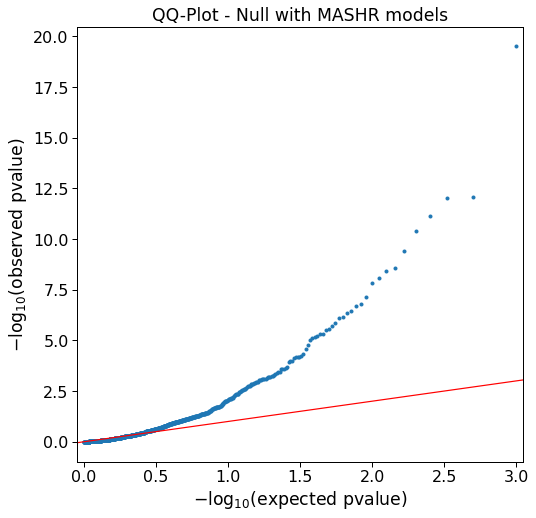

In [32]:
observed_data = -np.log10(data)
expected_data = -np.log10(uniform_data)

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel("$-\log_{10}$(expected pvalue)")
    ax.set_ylabel("$-\log_{10}$(observed pvalue)")
    ax.set_title("QQ-Plot - Null with MASHR models")

# LV45: why type I errors are so high?

In [42]:
from data.recount2 import LVAnalysis

In [33]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [34]:
multiplier_z.shape

(6750, 987)

In [35]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
GAS6,0.000000,0.0,0.039438,0.0,0.050476,0.000000,0.0,0.000000,0.590949,0.000000,...,0.050125,0.00000,0.033407,0.000000,0.000000,0.005963,0.347362,0.0,0.000000,0.000000
MMP14,0.000000,0.0,0.000000,0.0,0.070072,0.000000,0.0,0.004904,1.720179,2.423595,...,0.000000,0.00000,0.001007,0.000000,0.035747,0.000000,0.000000,0.0,0.014978,0.000000
DSP,0.000000,0.0,0.000000,0.0,0.000000,0.041697,0.0,0.005718,0.000000,0.000000,...,0.020853,0.00000,0.000000,0.000000,0.000000,0.005774,0.000000,0.0,0.000000,0.416405
MARCKSL1,0.305212,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.161843,0.149471,...,0.027134,0.05272,0.000000,0.030189,0.060884,0.000000,0.000000,0.0,0.000000,0.448480
SPARC,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.014014,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.067779,0.0,0.122417,0.062665


In [38]:
multiplier_z["LV45"].sort_values(ascending=False).head(25)

HIST1H2BO    8.480948
HIST1H2BF    8.426226
HIST1H2BK    8.245903
HIST1H2BD    8.119013
HIST1H2BC    7.744137
HIST2H2BE    7.567785
HIST1H2AC    7.447932
HIST1H2AK    6.983840
HIST2H2AC    6.731329
HIST2H2BF    6.700409
HIST1H2AG    6.405812
HIST1H2BN    5.913649
HIST1H2AE    5.898213
HIST1H2AM    3.850329
HIST1H2BE    3.489655
HIST1H2BH    2.522366
HIST1H2BJ    2.467813
HIST1H2AD    2.403343
H2AFX        1.594301
HIST1H2BG    1.525977
HIST3H2BB    1.436435
HIST3H2A     1.268004
H2AFZ        1.221418
HIST1H4D     1.056777
HIST1H4I     0.865090
Name: LV45, dtype: float64

Interesting, where are all those HIST genes from?

In [43]:
lv_obj = LVAnalysis("LV45")

In [45]:
lv_obj.lv_genes.head(20)

,gene_name,LV45,gene_band
0,HIST1H2BO,8.480948,6p22.1
1,HIST1H2BF,8.426226,6p22.2
2,HIST1H2BK,8.245903,6p22.1
3,HIST1H2BD,8.119013,6p22.2
4,HIST1H2BC,7.744137,6p22.2
5,HIST2H2BE,7.567785,NaN
6,HIST1H2AC,7.447932,6p22.2
7,HIST1H2AK,6.983840,NaN
8,HIST2H2AC,6.731329,NaN
9,HIST2H2BF,6.700409,1q21.2


They are all from the same band, very likely causing high type I errors.